In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# to make torch.use_deterministic_algorithms(True) work
os.environ.update({'CUBLAS_WORKSPACE_CONFIG': ':4096:8'})

In [3]:
import random

import numpy as np
import torch


seed = 3407
_ = torch.manual_seed(seed)
rng = np.random.default_rng(seed)
random.seed(seed)
torch.use_deterministic_algorithms(True)

In [4]:
from src.augmentations import DefaultWaveAugmentations, DefaultWave2Spec
from src.configs import DefaultConfig
from src.data_utils import Collator, get_sampler, SpeechCommandsDataset
from src.metrics import count_FA_FR, get_au_fa_fr
from src.models import CRNN
from src.train_utils import count_parameters, train, validation

In [5]:
DATA_DIR = 'data/speech_commands'

In [6]:
dataset = SpeechCommandsDataset(
    path2dir=DATA_DIR, keywords=DefaultConfig.keyword
)

In [7]:
indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)
train_set = SpeechCommandsDataset(csv=train_df, transform=DefaultWaveAugmentations(DATA_DIR))
val_set = SpeechCommandsDataset(csv=val_df)

In [8]:
train_sampler = get_sampler(train_set.csv['label'].values)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=DefaultConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=2, pin_memory=True)

val_loader = torch.utils.data.DataLoader(val_set, batch_size=DefaultConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

In [9]:
train_wave2spec = DefaultWave2Spec(is_train=True, config=DefaultConfig)
val_wave2spec = DefaultWave2Spec(is_train=False, config=DefaultConfig)

In [10]:
config = DefaultConfig()
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)


In [11]:
count_parameters(model)

70443

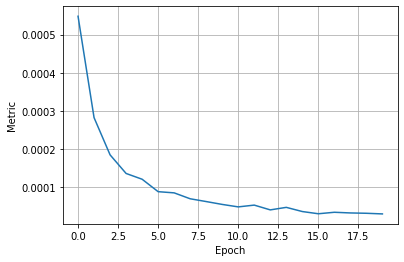

END OF EPOCH 20


In [12]:
best_score, best_model = train(
    config.num_epochs,
    model,
    opt,
    (train_loader, val_loader),
    (train_wave2spec, val_wave2spec),
    config.device,
    make_plots=True,
)

In [13]:
torch.save(best_model, 'checkpoints/baseline.pth')

In [14]:
best_score

2.9873543191095338e-05